In [1]:
# import libraries
import os
import json
import requests
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
sns.set_theme(style="whitegrid")

In [2]:
try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except Exception as e:
    print("skipping sklearnex")
    pass

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
# import data
df = pd.read_csv('data/tracks_1000Unique+_with_duplicates.csv', index_col=False)
df.drop_duplicates('track_id', keep='first', inplace=True)
df.drop(columns={'Unnamed: 0'}, inplace=True)

In [4]:
del df["track_id"]; del df["artist_name"]; del df["track_name"]

### This Version will be working with 1000 Samples for each Genre

In [5]:
# Make it 1000 for each category
result = df.groupby("genre").apply(lambda x: x.head(1000)).reset_index(drop=True)
result

,genre,popularity,duplicated_x,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,duplicated_y
0,blues,77.0,False,0.274,0.348,5,-8.631,1,0.0293,0.547000,0.013300,0.3340,0.328,87.430,179693,3,False
1,blues,77.0,False,0.756,0.401,7,-10.702,0,0.0526,0.582000,0.011000,0.0541,0.514,101.954,199396,4,False
2,blues,74.0,False,0.581,0.687,6,-5.400,1,0.1050,0.229000,0.000000,0.1090,0.187,76.014,240600,4,False
3,blues,75.0,False,0.635,0.184,8,-10.785,1,0.0456,0.665000,0.000000,0.1460,0.177,128.424,240200,4,False
4,blues,75.0,False,0.477,0.433,11,-6.473,0,0.0247,0.689000,0.000195,0.1510,0.611,82.520,156653,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,techno,29.0,False,0.732,0.875,4,-5.842,0,0.0326,0.126000,0.000234,0.2200,0.933,132.987,214960,4,False
9996,techno,49.0,False,0.738,0.816,4,-6.304,0,0.0322,0.000877,0.785000,0.1340,0.884,129.998,198793,4,False
9997,techno,35.0,False,0.610,0.875,5,-5.455,0,0.0333,0.028300,0.908000,0.1140,0.873,144.999,309023,4,False
9998,techno,44.0,False,0.756,0.527,8,-11.861,1,0.0428,0.002010,0.509000,0.1120,0.248,119.996,416500,4,False


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

y_tmp = pd.DataFrame(result["genre"])
X = result.drop("genre", axis=1)
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_tmp)
cols = [x.replace("x0_", "") for x in encoder.get_feature_names()]
display(len(cols))
y = pd.DataFrame(encoder.transform(y_tmp), columns=cols)
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)# , stratify=y > 0

X:\Games\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


10

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

def scaler_pipeline():
    return make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler())

def scaler_pipeline_pwr():
    return make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler(), PowerTransformer(method='yeo-johnson', standardize=True))

ct = ColumnTransformer([
        ('stdscaled', StandardScaler(), ["popularity","danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms","time_signature"]),
       ], remainder='passthrough')

X_train_scaled = ct.fit_transform(X_train_org)
X_test_scaled  = ct.transform(X_test_org)
feature_names = ct.get_feature_names_out()
X_train = X_train_scaled
X_test  = X_test_scaled

In [8]:
feature_names

array(['stdscaled__popularity', 'stdscaled__danceability',
       'stdscaled__energy', 'stdscaled__key', 'stdscaled__loudness',
       'stdscaled__mode', 'stdscaled__speechiness',
       'stdscaled__acousticness', 'stdscaled__instrumentalness',
       'stdscaled__liveness', 'stdscaled__valence', 'stdscaled__tempo',
       'stdscaled__duration_ms', 'stdscaled__time_signature',
       'remainder__duplicated_x', 'remainder__duplicated_y'], dtype=object)

In [9]:
y_train_rap = y_train.rap
y_train.columns

Index(['blues', 'classical', 'electronic', 'funk', 'jazz', 'metal', 'r&b',
       'rap', 'rock', 'techno'],
      dtype='object')

## Multiclass Classifiers

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [11]:
classifiers = [
    ('KNNClassifier',     (KNeighborsClassifier())),
    ('RandomForestClassifier', (RandomForestClassifier(random_state=42))),
    ('DecisionTreeClassifier', (DecisionTreeClassifier(random_state=42)))
]

result_C = {}

for classifier_tuple in classifiers:
    name, classifier = classifier_tuple
    cv_score = cross_val_score(classifier, X_train, y_train, cv=3, scoring='accuracy')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy_score_result = accuracy_score(y_test, y_pred)
    print(f"[{name}]CSV Score:", cv_score)
    print(f"[{name}]Predict accuracy:", accuracy_score_result)
    result_C[name] = y_pred

[KNNClassifier]CSV Score: [0.35620547 0.33970754 0.3675919 ]
[KNNClassifier]Predict accuracy: 0.3475


X:\Games\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
X:\Games\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
X:\Games\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassi

[RandomForestClassifier]CSV Score: [0.36070491 0.36745407 0.3675919 ]
[RandomForestClassifier]Predict accuracy: 0.3715
[DecisionTreeClassifier]CSV Score: [0.47094113 0.4728159  0.49024756]
[DecisionTreeClassifier]Predict accuracy: 0.484


<Figure size 640x480 with 0 Axes>

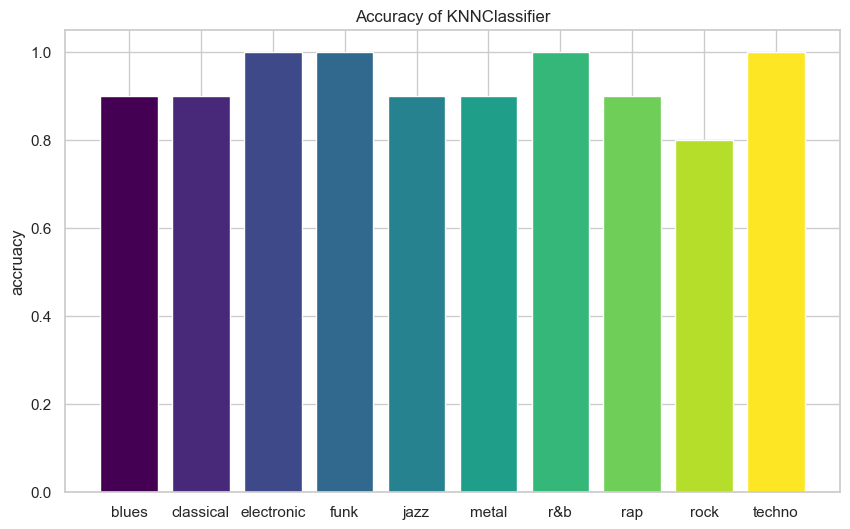

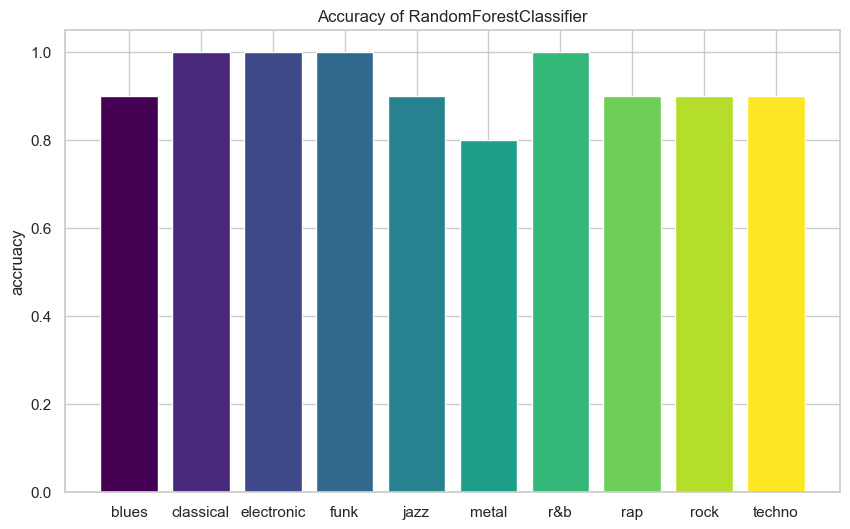

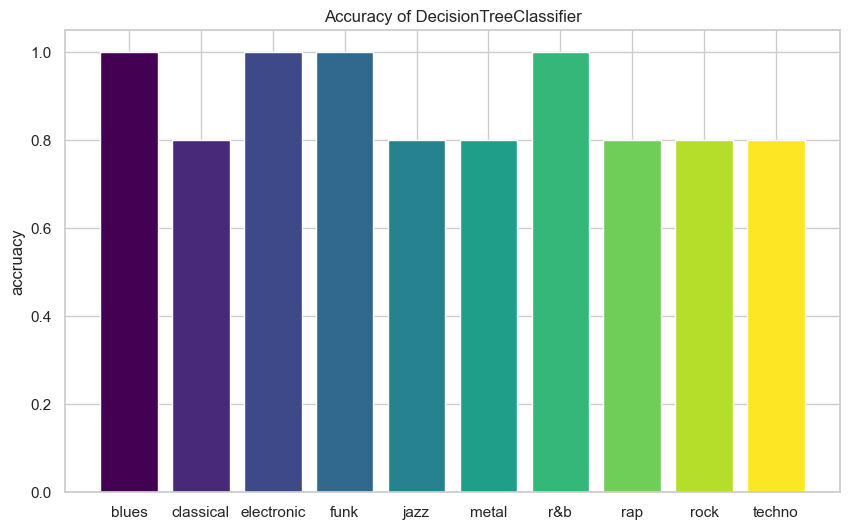

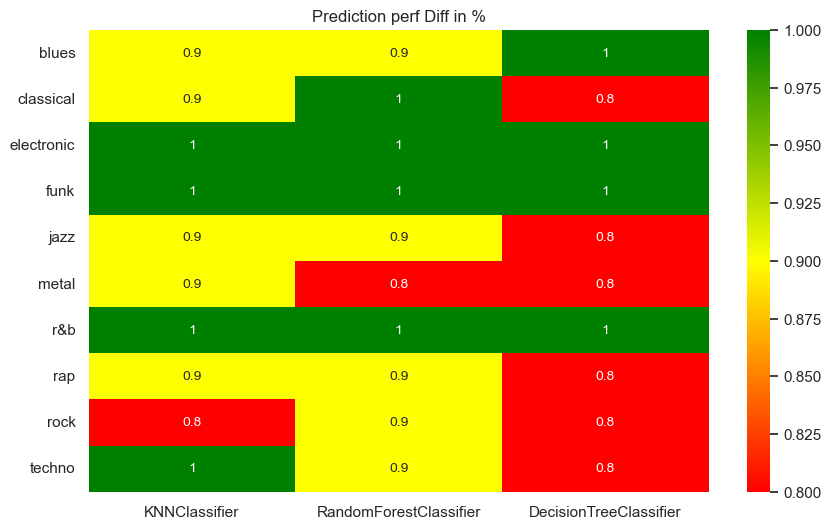

<Figure size 640x480 with 0 Axes>

In [12]:
colormap = plt.cm.get_cmap('viridis', len(y_test.columns))
data_for_heatmap = {}
for key in result_C.keys():
    prediction = result_C[key]
    data_for_heatmap[key] = []
    _to_display_X = []
    _to_display_Y = []
    fig, ax = plt.subplots(figsize=(10, 6))
    for genre_index in range(len(y_test.columns)):
        genre = y_test.columns[genre_index]
        score = accuracy_score(y_test.iloc[genre_index, :], prediction[genre_index, :])
        _to_display_X += [ genre ]
        _to_display_Y += [ score ]
    ax.bar(_to_display_X, _to_display_Y, color=colormap(range(len(y_test.columns))))
    ax.set_title("Accuracy of "+ key)
    ax.set_ylabel("accruacy")
    data_for_heatmap[key] = _to_display_Y

heatmap_df = pd.DataFrame(data_for_heatmap, columns=result_C.keys(), index=y_test.keys())
"""
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['crimson', 'yellow', 'lime'])
sns.heatmap(data_for_heatmap, annot=True, cmap=cmap, annot_kws={'fontsize': 6})
# Plot data on a logarithmic scale
plt.title("Prediction perf Diff in %")
plt.figure()"""

from matplotlib.colors import LinearSegmentedColormap
fig, ax = plt.subplots(figsize=(10, 6))
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['red', 'yellow', 'green'])
sns.heatmap(heatmap_df, annot=True, cmap=cmap, annot_kws={'fontsize': 10})
# Plot data on a logarithmic scale
plt.title("Prediction perf Diff in %")
plt.figure()

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error, get_scorer_names
from sklearn.neighbors import KNeighborsRegressor

## Multiclass Regressors (Experimentation)

In [14]:
classifiers = [
    #('LogisticRegression',     (LogisticRegression(random_state=42))),
    ('RandomForestRegression', (RandomForestRegressor(random_state=42, max_features=1.0))),
    ('DecisionTreeRegression', (DecisionTreeRegressor(random_state=42, max_features=1.0))),
    ('KNearestNeighboursRegression', KNeighborsRegressor()),
]

result = {}
scoring_metric = make_scorer(mean_squared_error, greater_is_better=False) #smaller is better
for classifier_tuple in classifiers:
    name, classifier = classifier_tuple
    cv_score = cross_val_score(classifier, X_train, y_train, cv=3, scoring=scoring_metric)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy_score_result = mean_squared_error(y_test, y_pred)
    print(f"[{name}]CSV Score:", cv_score)
    print(f"[{name}]Predict error:", accuracy_score_result)
    result[name] = y_pred
    


[RandomForestRegression]CSV Score: [-0.05105318 -0.0534972  -0.05044512]
[RandomForestRegression]Predict error: 0.05070220000000021
[DecisionTreeRegression]CSV Score: [-0.10431196 -0.10536183 -0.10217554]
[DecisionTreeRegression]Predict error: 0.10289999999999999
[KNearestNeighboursRegression]CSV Score: [-0.06978928 -0.07080915 -0.06796999]
[KNearestNeighboursRegression]Predict error: 0.06964799999999996


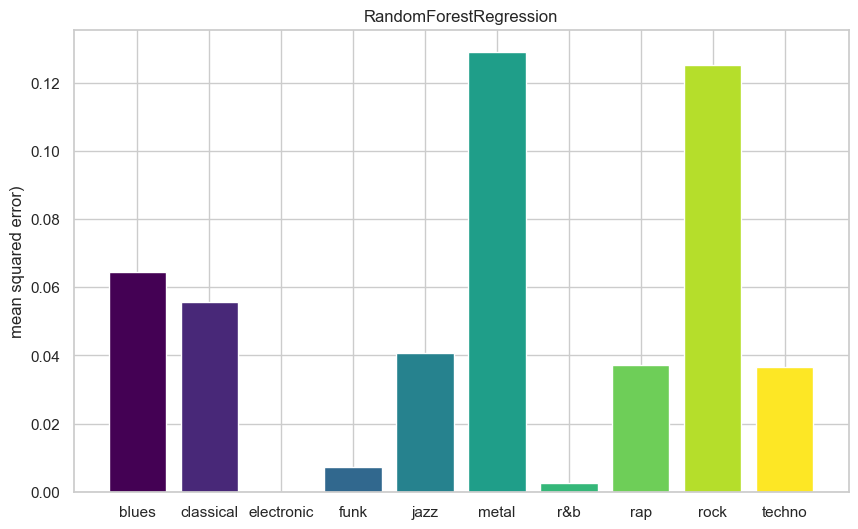

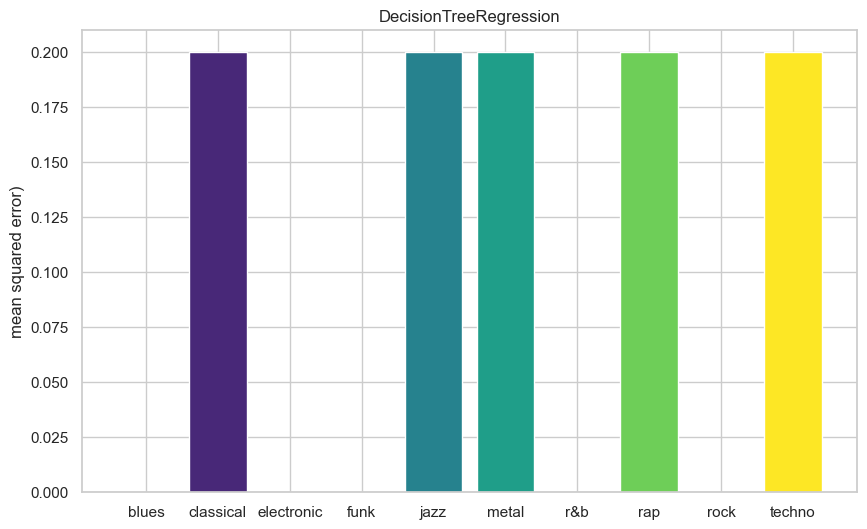

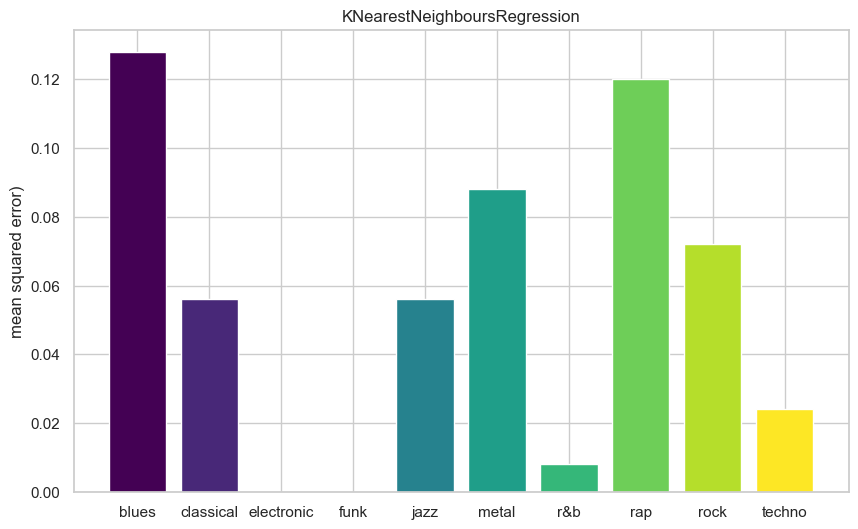

In [15]:
#tmp = pd.DataFrame(y_test, columns=y_test.columns)
colormap = plt.cm.get_cmap('viridis', len(y_test.columns))
for key in result.keys():
    prediction = result[key]
    _to_display_X = []
    _to_display_Y = []
    fig, ax = plt.subplots(figsize=(10, 6))
    for genre_index in range(len(y_test.columns)):
        genre = y_test.columns[genre_index]
        mse = mean_squared_error(y_test.iloc[genre_index, :], prediction[genre_index, :])
        _to_display_X += [ genre ]
        _to_display_Y += [ mse ]
    ax.bar(_to_display_X, _to_display_Y, color=colormap(range(len(y_test.columns))))
    ax.set_title(key)
    ax.set_ylabel("mean squared error)")

## Hyper Parameter tuning of the Multiclass Classifiers

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold
cv = KFold(3, random_state=42, shuffle=True)

In [25]:
RFC_param_grid = {
    'n_estimators': randint(5, 1000),
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
}
KNN_param_grid = {
    'n_neighbors': randint(len(y_test.columns)//2, len(y_test.columns) + 5),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}
DTC_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
}
classifiers = [
    ('KNNClassifier',     (KNeighborsClassifier()), KNN_param_grid),
    ('RandomForestClassifier', (RandomForestClassifier(random_state=42, max_features='sqrt')), RFC_param_grid),
    ('DecisionTreeClassifier', (DecisionTreeClassifier(random_state=42)), DTC_param_grid)
]

result_RandomSearchCV = {}

for c in classifiers:
    _name, _classifier, _params = c
    # Perform random search with cross-validation
    random_search = RandomizedSearchCV(_classifier, n_jobs=-1, scoring='accuracy', random_state=42, verbose=3, param_distributions=_params, n_iter=100, cv=cv)
    random_search.fit(X_train, y_train)
    result_RandomSearchCV[_name] = {"classifier":_classifier, "params":_params, "RandomSearchResult":random_search}
    # Print the best hyperparameters and score
    print(f"[{_name}]Best Hyperparameters: ", random_search.best_params_)
    print(f"[{_name}]Best Score: ", random_search.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[KNNClassifier]Best Hyperparameters:  {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
[KNNClassifier]Best Score:  0.39374991854450303
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[RandomForestClassifier]Best Hyperparameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 507}
[RandomForestClassifier]Best Score:  0.36724948016156644
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[DecisionTreeClassifier]Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
[DecisionTreeClassifier]Best Score:  0.4903746090253347


In [26]:
result_rs = {}
for name, obj in result_RandomSearchCV.items():
    best_params = obj["RandomSearchResult"].best_params_
    _class_ref = obj["classifier"].__class__
    if _class_ref != KNeighborsClassifier:
        best_params["random_state"] = 42
        if _class_ref == RandomForestClassifier:
            best_params["max_features"] ='sqrt'
    _new_classifier_instance = obj["classifier"].__class__(**best_params)   
    _new_classifier_instance.fit(X_train, y_train)    
    y_pred = _new_classifier_instance.predict(X_test)
    result_rs[name] = y_pred

<Figure size 640x480 with 0 Axes>

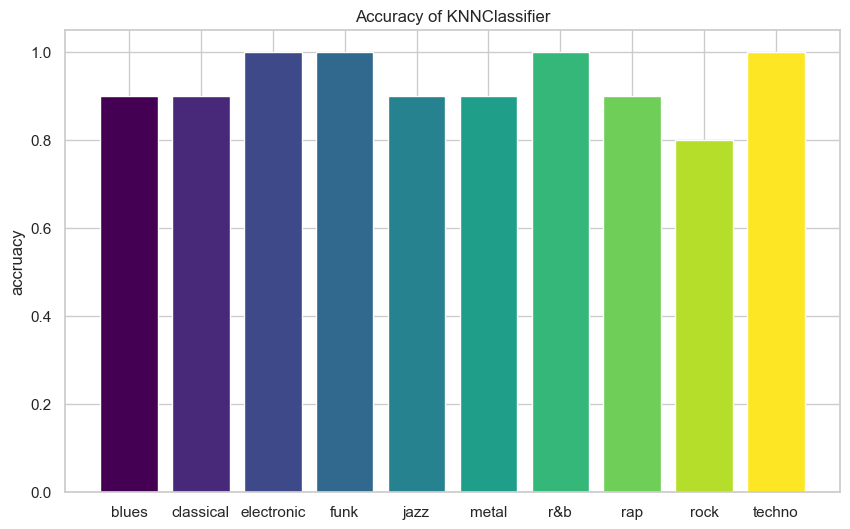

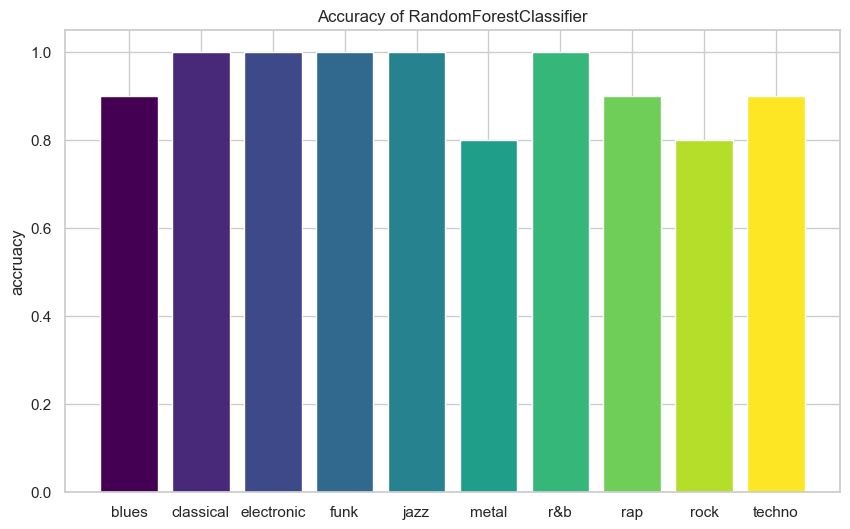

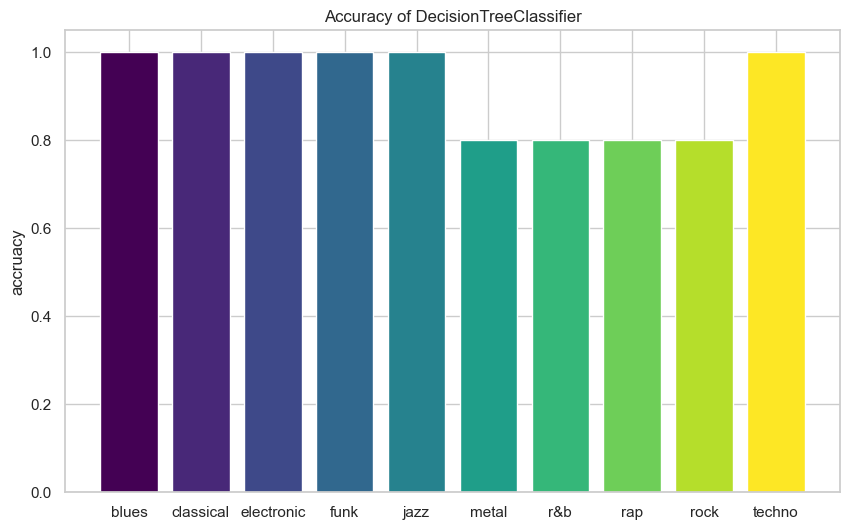

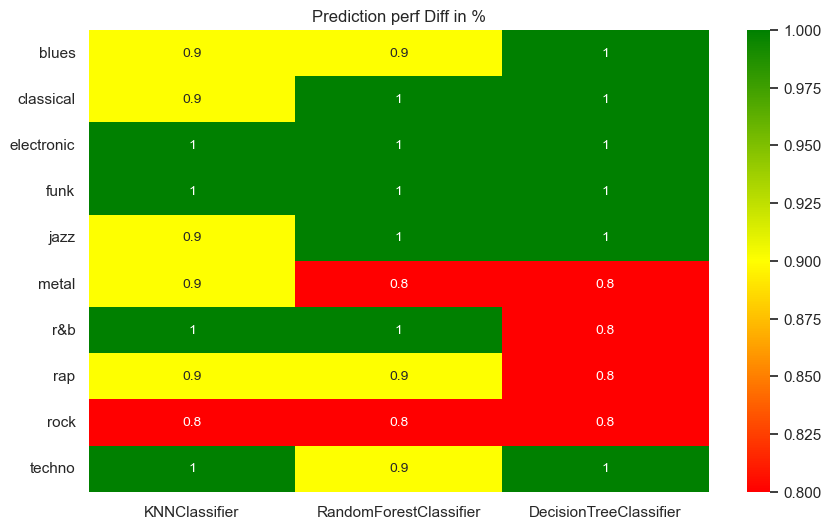

<Figure size 640x480 with 0 Axes>

In [27]:
colormap = plt.cm.get_cmap('viridis', len(y_test.columns))
data_for_heatmap = {}
for key in result_rs.keys():
    prediction = result_rs[key]
    data_for_heatmap[key] = []
    _to_display_X = []
    _to_display_Y = []
    fig, ax = plt.subplots(figsize=(10, 6))
    for genre_index in range(len(y_test.columns)):
        genre = y_test.columns[genre_index]
        score = accuracy_score(y_test.iloc[genre_index, :], prediction[genre_index, :])
        _to_display_X += [ genre ]
        _to_display_Y += [ score ]
    ax.bar(_to_display_X, _to_display_Y, color=colormap(range(len(y_test.columns))))
    ax.set_title("Accuracy of "+ key)
    ax.set_ylabel("accruacy")
    data_for_heatmap[key] = _to_display_Y

heatmap_df_optimized = pd.DataFrame(data_for_heatmap, columns=result_rs.keys(), index=y_test.keys())
"""
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['crimson', 'yellow', 'lime'])
sns.heatmap(data_for_heatmap, annot=True, cmap=cmap, annot_kws={'fontsize': 6})
# Plot data on a logarithmic scale
plt.title("Prediction perf Diff in %")
plt.figure()"""

from matplotlib.colors import LinearSegmentedColormap
fig, ax = plt.subplots(figsize=(10, 6))
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['red', 'yellow', 'green'])
sns.heatmap(heatmap_df_optimized, annot=True, cmap=cmap, annot_kws={'fontsize': 10})
# Plot data on a logarithmic scale
plt.title("Prediction perf Diff in %")
plt.figure()

## What is the improvement?

In [28]:
heatmap_diff = heatmap_df_optimized - heatmap_df
heatmap_diff

,KNNClassifier,RandomForestClassifier,DecisionTreeClassifier
blues,0.0,0.0,0.0
classical,0.0,0.0,0.2
electronic,0.0,0.0,0.0
funk,0.0,0.0,0.0
jazz,0.0,0.1,0.2
metal,0.0,0.0,0.0
r&b,0.0,0.0,-0.2
rap,0.0,0.0,0.0
rock,0.0,-0.1,0.0
techno,0.0,0.0,0.2


## Lets Visualize it!

<Figure size 640x480 with 0 Axes>

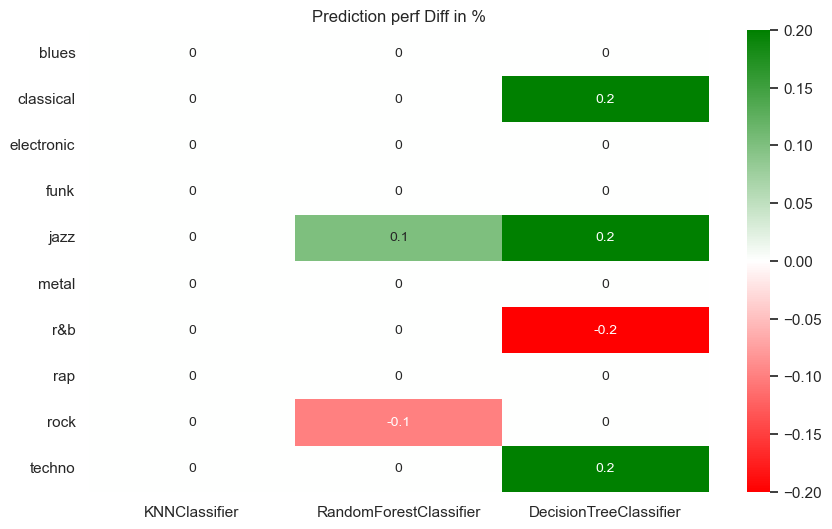

<Figure size 640x480 with 0 Axes>

In [29]:
from matplotlib.colors import LinearSegmentedColormap
fig, ax = plt.subplots(figsize=(10, 6))
_range = abs(heatmap_diff.max().max() - heatmap_diff.min().min())
zero_position = np.abs(heatmap_diff.min().min()) / _range
color_map_list = [(0, 'red'), (zero_position, 'white'), (1.0, "green")]

cmap = LinearSegmentedColormap.from_list('custom_cmap', color_map_list)
sns.heatmap(heatmap_diff, annot=True, cmap=cmap, annot_kws={'fontsize': 10})
# Plot data on a logarithmic scale
plt.title("Prediction perf Diff in %")
plt.figure()